In [6]:
import pandas as pd
import geopandas as gpd
import minimod
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact, IntSlider

data_folder = 'Optimization Work/demewoz_lives_saved/data_files/'

effective_coverage_folder = data_folder + 'effective_coverage/'
cost_folder = data_folder + 'new_cost_benefits/'

In [7]:
# Get intervention names to change
zinc_eff_cov = (
pd.read_excel(effective_coverage_folder + 'April_20_zinc_effective coverage.xlsx', sheet_name= 'Minimum Addtional intake(MAI)', usecols = 'A,B,C')
)

long_intervention_names = zinc_eff_cov['Zinc interventions '].unique().tolist()
short_intervention_names = ['zflourzcube', 'zcube', 'zflour']
intervention_rename_list = {k:v for k,v in zip(long_intervention_names, short_intervention_names)}


In [8]:
# First load in cost data
costs = pd.read_excel(cost_folder + 'lives_saved_costs.xlsx', sheet_name='costs')

# Then VA Effective Coverage
zinc_eff_cov = (
pd.read_excel(effective_coverage_folder + 'April_20_zinc_effective coverage.xlsx', sheet_name= 'Minimum Addtional intake(MAI)', usecols = 'A,B,C')
.assign(intervention = lambda df: df['Zinc interventions ']
.replace(intervention_rename_list),
region = lambda df: df['zoneName'].str.strip())
)

# 6-59 Mos. Children
pop = (
pd.read_excel(effective_coverage_folder + 'Cameroon Population age6-59 months.xlsx', skiprows=1)
.replace({'Region' : {'Urban' : 'Cities'}})
.loc[:, ['Region'] + [f"Sum of {year}" for year in range(2020, 2030,1)]]
.rename({'Region' : 'region'}, axis=1)
)
## Using 2020 - 2029 -> 1-10


In [9]:
def year_func(year, col = 'effective_coverage'):
    return lambda df: (df[col]/100)*df[f'Sum of {year}']

df_benefits_mean = (
zinc_eff_cov
.merge(pop, on = 'region')
.assign(
**{str(num + 1) : year_func(year) for num, year in enumerate(range(2020, 2030,1))})
[['intervention', 'region'] + [str(x) for x in range(1,11,1)]]
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({'level_2' : 'time',
0 : 'eff_cov_mean'}, axis=1)
.assign(time = lambda df: df['time'].astype(int))
)

# df_benefits_sd = (
# zinc_eff_cov
# .merge(pop, on = 'region')
# .assign(
# **{str(num +     1) : year_func(year, 'effective_coverage_SE') for num, year in enumerate(range(2020, 2030,1))})
# [['intervention', 'region'] + [str(x) for x in range(1,11,1)]]
# .set_index(['intervention', 'region'])
# .stack()
# .reset_index()
# .rename({'level_2' : 'time', 0 : 'eff_cov_sd'}, axis=1)
# .assign(time = lambda df: df['time'].astype(int))
# )

# df_benefits = df_benefits_mean.merge(df_benefits_sd, on  = ['intervention', 'region', 'time'])
df_benefits = df_benefits_mean

# Construct BAU
# We need to bring in the fflour33 from the folate

In [10]:
df_benefits

,intervention,region,time,eff_cov_mean
0,zflourzcube,Cities,1,393231.2150
1,zflourzcube,Cities,2,404560.7500
2,zflourzcube,Cities,3,416081.2175
3,zflourzcube,Cities,4,427584.9825
4,zflourzcube,Cities,5,438820.1975
...,...,...,...,...
85,zflour,South,6,294523.9080
86,zflour,South,7,295568.0000
87,zflour,South,8,296455.3900
88,zflour,South,9,297104.7380


In [5]:
# Create costs
df_costs = (
costs
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({'level_2' : 'time', 0 : 'costs'}, axis=1)
)

In [44]:
df = df_benefits.merge(df_costs, on = ['intervention', 'region', 'time'])


In [42]:
# Create function to make data adjustments
def observation_adjustment(data, int1, int2, time_to_replace, space_to_replace = slice(None)):
    
    df = data.copy(deep = True)

    if isinstance(int2, str):
        df_int2 = df.loc[(int2, space_to_replace, time_to_replace)]
        df.loc[(int1, space_to_replace, time_to_replace), :] = df_int2.values
    elif int2 == 0:
        df.loc[(int1, space_to_replace, time_to_replace), :] = 0

    print(f"Changed {int1} to {int2}")

    return df

In [46]:
df_adjusted = (df.set_index(['intervention', 'region', 'time'])
.pipe(observation_adjustment,
int1 = "zcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "zflourzcube",
int2 = "zflour",
time_to_replace = [1,2,3]))

Changed zcube to 0
Changed zflourzcube to zflour


## Summary Tables

In [47]:
df_adjusted.index.get_level_values(level=0).unique()

Index(['zflourzcube', 'zcube', 'zflour'], dtype='object', name='intervention')

In [51]:

s = minimod.utils.summary.PreOptimizationDataSummary(
    data = df_adjusted.reset_index(),
    benefit_col= 'eff_cov_mean',
    cost_col= 'costs',
    intervention_col='intervention',
    space_col= 'region',
    time_col='time',
    benefit_title='Children Effectively Covered (Zinc)',
    intervention_subset=['zflour', 'zcube', 'zflourzcube'],
    intervention_subset_titles={'zflour' : 'Flour with Zinc',
    'zcube' : 'Cube with Zinc',
    'zflourzcube' : 'Flour + Cube with Zinc',
    'oil' : 'Fortified Oil (75%)',
    'maxoil' : 'Fortified Oil (100%)'},
    bau_intervention = 'oil'
)

s.summary_table(variables_of_interest= {'Cost per Child ($)' : 'cost_per_benefit'}, grouping = 'over_space', style = 'markdown')


,Intervention,Regions,Children Effectively Covered (Zinc),Costs ($),Cost per Child ($)
4,Flour with Zinc,Cities,"3,648,096","2,369,630",0.650000
6,Flour with Zinc,North,"2,342,109","1,433,321",0.610000
7,Flour with Zinc,South,"2,932,984","2,266,598",0.770000
5,Flour with Zinc,National,"8,923,189","6,069,549",0.680000
0,Cube with Zinc,Cities,0,"1,156,882",inf
2,Cube with Zinc,North,0,"1,816,881",inf
3,Cube with Zinc,South,0,"1,998,896",inf
1,Cube with Zinc,National,0,"4,972,660",inf
8,Flour + Cube with Zinc,Cities,"4,211,882","3,526,512",0.840000
10,Flour + Cube with Zinc,North,"3,129,123","3,250,202",1.040000


In [55]:
m = minimod.Minimod(solver_type = 'costmin',
data = df_adjusted,
benefit_col = 'eff_cov_mean',
cost_col = 'costs',
space_col = 'region',
all_space = ['zcube', 'zflour'],
all_time = ['zcube', 'zflour'],
time_subset = [1,2,3],
benefit_title = 'Children Effectively Covered (Zinc)',
minimum_benefit = 'zflour',
)

[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.4dev
                Solver: CBC,
                Show Output: True
                
                


In [56]:
m.fit()

[Note]: Optimizing...
[Note]: Optimal Solution Found


In [57]:
m.report()

+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 1                          |
+----------------------------+----------------------------+
+-----------------------------+------+
| No. of Variables:           |   90 |
| No. of Integer Variables:   |   90 |
| No. of Constraints          |  313 |
| No. of Non-zeros in Constr. | 1278 |
+-----------------------------+------+
Interventions Chosen:
+-------------------------------------------+-------------+
| Minimum Benefit                           | 7.81179e+06 |
| Objective Bounds                          | 6.06955e+06 |
| Total Cost                                | 6.06955e+06 |
| Total Children Effectively Covered (Zinc) | 7.81179e+06 |
+-----------------------

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f02af93b760>)

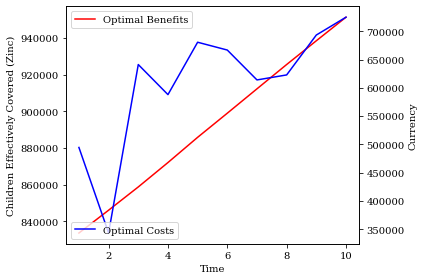

In [58]:
m.plot_time()


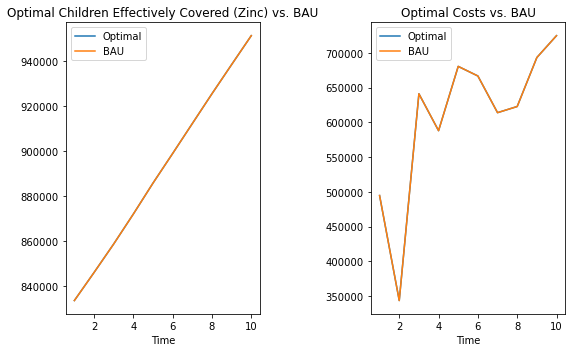

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize = (8,5))
m.plot_bau_time(ax=ax1)
m.plot_bau_time(opt_variable = 'c', ax=ax2)
plt.savefig("low_bau.png", dpi=600)

In [60]:
# Load data
geo_df = gpd.read_file("examples/data/maps/cameroon/CAM.shp")

# Now we create the boundaries for North, South and Cities
# Based on "Measuring Costs of Vitamin A..., Table 2"
north = r"Adamaoua|Nord|Extreme-Nord"
south = r"Centre|Est|Nord-Ouest|Ouest|Sud|Sud-Ouest"
cities= r"Littoral" # Duala
# Yaounde is in Mfoundi
geo_df.loc[lambda df: df['ADM1'].str.contains(north), 'space'] = 'North'
geo_df.loc[lambda df: df['ADM1'].str.contains(south), 'space'] = 'South'
geo_df.loc[lambda df: df['ADM1'].str.contains(cities), 'space'] = 'Cities'
geo_df.loc[lambda df: df['ADM2'].str.contains(r"Mfoundi"), 'space'] = 'Cities'

# Now we aggregate the data to the `space` variable
agg_geo_df = geo_df.dissolve(by = 'space')


In [62]:
interact(m.plot_map_benchmark, 
intervention = fixed('zflour'), 
time = IntSlider(min=1, max=10, step=1, value=1), 
optimum_interest = ['b', 'c', 'cdb', 'cdc', 'cb', 'cc'], 
bench_intervention = fixed('zflour'),
map_df = fixed(agg_geo_df),
merge_key = fixed('space'),
save = fixed(None))

interactive(children=(IntSlider(value=1, description='time', max=10, min=1), Dropdown(description='optimum_int…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>